## 1. Planetary motion

### Part 1

This was straightforward enough (see the MATLAB files for documentation). The results of the 3 body motion, out to five years:

![31426 iterations](q1/trajectories-of-3-bodies-in-a-gravitational-field-over-31426-iterations.pdf)
![62854 iterations](q1/trajectories-of-3-bodies-in-a-gravitational-field-over-62854-iterations.pdf)
![90000 iterations](q1/trajectories-of-3-bodies-in-a-gravitational-field-over-90000-iterations.pdf)

We can plainly see the erratic motion of the mass at the center (a result of the fact that we're not using the center of mass reference frame) as well as mostly eliptical orbits (with severe deviations occuring when the small planets draw near one another).

### Part 2

Within 18,000 iterations, we see a slingshot effect; the outer
planet gets sufficiently close to the inner planet to "fling" it out into
a higher orbit.

Due to momentum conservation (and the fact that they provide the dominant
forces acting on one another during collision), the planets end up flying
off in near-opposite directions; this puts them on track to collide
again, since they're both in nearly the same elliptical orbit. This
result relies on their equal masses to turn momentum conservation into
equal/opposite velocities.

Unfortunately, my energy tracking is off; I had trouble figuring out
the units. The graphs have the same forms as one another, so I know
it's just a dumb scaling issue.

With too large of a time step, things get wacky:

![too large of a time step](q1/trajectories-of-3-bodies-in-a-gravitational-field-over-25000-iterations.pdf)



(Again), my energy tracking is off; I had trouble figuring out
the units. The graphs have the same forms as one another, so I know
it's just a scaling issue. That said, there is very clearly a completely
unphysical, extremely sudden spike in kinetic energy as a result of the
too-short timescale.

However, we can address the problem conceptually using analytical
reasoning. Since the acceleration scales like 1/r^2, the maximum is much
larger for this trial (due to the close passes). This means that a Taylor
series in time, with a now-huge acceleration factor for the t^2 power,
would no longer be linear for what might have previously been a
sufficiently small time scale. Without resorting to higher-order
approximations, the only choice for maintaining accuracy is to use a
smaller time step.

Compare the results of Part 3a.

Smaller timestep leads to much smoother behaviour; decreasing it by an
order of magnitude removes the most egregiously anomalous energy
conservation violations and produces a smooth, albeit tight, bend where
the planets "slingshot" off of one another.

Much better:

![20000 iterations](q1/trajectories-of-3-bodies-in-a-gravitational-field-over-20000-iterations.pdf)

### Part 4

After a bunch of tweaking, this was one of my better "slingshots";
suffice it to say, it's a hard problem to eyeball. Better to write a 
program to iteratively seek out stronger slingshot boosts. Since this is an analytic problem,
we should be able to use some sort of reasonably standard optimization
routine for picking our next slingshot guess; it would at least be
better than eyeballing.
    
    numIterations   = 0.2e5;
    X               = 2e-5;
    mass            = [ 1 1e-2 0.5e-2 1e-5 ];
    initial         = zeros( 6, numBodies );
    initial( 1, 2 ) = 1;
    initial( 5, 2 ) = 1;
    initial( 1, 3 ) = 2/3;
    initial( 5, 3 ) = (2/3)^(-0.5);
    initial( 1, 4 ) = 0.99;
    initial( 4, 4 ) = -2.07;
    initial( 5, 4 ) = 1.19;


## 2. Molecular Dynamics for Liquid Argon

### Preliminaries

#### Relaxing energies using velocity rescaling after thermalization

Using Verlet's units, we have

$$
  T = 16 \sum_{i} \frac{v_{i}^{2}}{N}.
$$

Using the notation $T_{i}$ for the temperature of the $i^{th}$ particle,

$$
  T_{i} = 16 v_{i}^{2}
$$

and

$$
  T = \langle T_{i} \rangle.
$$

We want to rescale the velocities $\{ v_{i} \}$. Define the set of rescaled temperatures $\{ \tilde{T}_{i} \}$ such that

$$
  \langle \tilde{T}_{i} \rangle \equiv T_{desired}.
$$

To find the relationship between $\{ \tilde{T}_{i} \}$ and $\{ T_{i} \}$, note that

$$
  T_{desired} = \bigg( \frac{T_{desired}}{T} \bigg) T
  = \bigg( \frac{T_{desired}}{T} \bigg) \langle T_{i} \rangle
  = \bigg \langle \frac{T_{desired}}{T} T_{i} \bigg \rangle
$$

giving

$$
  \tilde{T}_{i} = \frac{T_{desired}}{T} T_{i}
$$

as a valid rescaling of $T$, with which we can calculate the velocity rescaling $\tilde{v}_{i}$ as

$$
  \tilde{v}_{i} = \sqrt{ \frac{T_{desired}}{T} } v_{i}.
$$

This gives us a way of rescaling velocities to fit a desired temperature, which, through repeated application, we can use to relax the system to a desired temperature.

#### Finding temperature and pressure from the kinetic and potential energies and the virial

We can easily find the temperature, $T$, using the simple relation

$$
  KE = \frac{f}{2}T = \frac{3N}{2}T,
$$

where $f$ is the number of degrees of freedom and $N$ is the number of particles (for my simulation I set $N=1000$). This easily gives $T = 2KE/3N$.

### Implementation notes

I initially implemented Verlet's algorithm using MATLAB, but encountered several bugs and speed issues and decided to reimplement it in Julia. This proved to be a challenge in its own right, since Julia is a relatively new and sometimes ill-documented language, but led to nicely extensible, fast, open-source code.

I defined a Julia type called `MolecularDynamicsTrial` to store all data associated with the simulation, and I saved my simulations using HDF5 formatting. Since the resulting simulation files are very large (around 1 GB for a 10,000 iteration simulation), I have not included them with the write up. A Trial object keeps track of the total number of intended steps, the current step of the simulation, the initial parameters of the simulation, and the details at every step. Trials can be constructed, resized, duplicated, sampled, saved to file, and loaded from file using a host of methods I created. My trial constructor automatically calculates side length based on density and particle number. They can be run for a customizable number of steps, or until finished. This flexibility and transparency was useful in debugging.

By replacing my looping algorithms with heavily vectorized code, explicitly typing relevant variables, and strategically optimizing bottlenecks, I was able to get extremely fast steps on the order of 0.25 seconds per iteration with 1,000 particles. I implemented the "trick" that Verlet discussed for only adding up forces of nearby particles, which also proved helpful.

I was initially planning on implementing my own indexing system for the particles, which only compares inter-particle distances if particles are in the same (or adjacent) subcells of an adjustable size. By my calculations, and based on tests I ran with the MATLAB code, this cuts down the number of calculations required for Verlet's trick by a factor of around 30. I successfully implemented this device in my MATLAB code, but the Julia code was (quite amazingly) already very fast without it for $N=1000$, so I didn't bother reimplementing my indexing system. It is worth mentioning, though, indexings system because it takes only $O(N)$ calculations per step by relying on particle positions to advantageously sort the particles before bothering to compare them. Even Verlet's improved indexing method still takes $O(N^2)$ steps every few turns. This means that significantly larger scale simulations are rendered feasible through its use. 

I wrote a placement algorithm that initially places all of the particles on a uniform grid (again, automatically calculated based on density and quantity), and then slightly shifts each particle's location by a random amount in each direction. All particles start at rest and are given time to thermalize even from initial placement, thermalization seemed to occur some time before the 200th step). This approach allowed me to avoid problems introduced by particles starting too close together, while also allowing for some randomness and for an initial breaking of symmetry to get things thermalized more quickly (if they all start precisely at the lattice points of a grid, then symmetry implies that total force should be zero; the only 

I recored potential energy, kinetic energy, and the virial every ten steps. I did the same with the speeds of each particle for a total of 2,000,000 speed measurements, 1,600,000 of which were post-relaxation/thermalization. I let the particles thermalize for 200 steps before rescaling the velocities by $T_{desired}/T_{avg}$, where $T_{avg}$ was the mean of the most recent 50 temperatures (in order to level out fluctuations). I did this 20 times (total of 4,000 steps) and then ran for another 16,000 steps. The average temperatures in the post-relaxation steps were 1.068 (vs. the desired 1.069) and 1.300 (vs. the desired 1.304), which indicates that the thermalization approach was mostly successful, though it would have certainly benefited from lengthier thermalizations and larger samples for the means used in the relaxation step. The temperature graphs below show the thermalization process (first 4,000 steps) followed by slight fluctuations for the rest of the simulation:

In [1]:
include("q2/plot2.jl");

LoadError: At least one finite value must be provided to formatter.
while loading /Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set02/q2/plot2.jl, in expression starting on line 77
while loading In[1], in expression starting on line 1

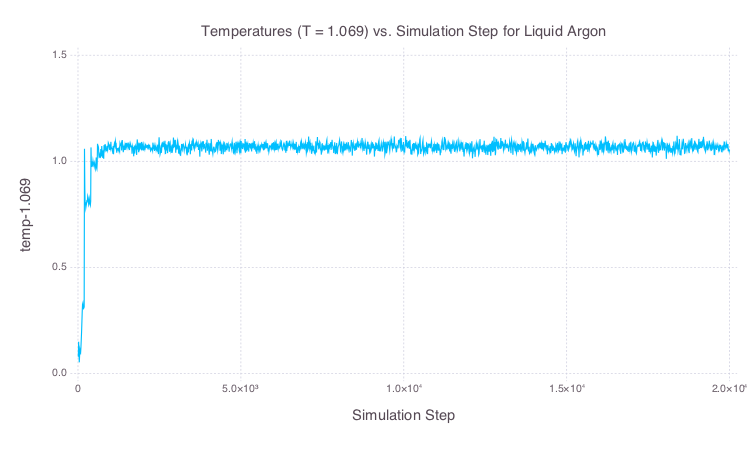

In [43]:
temp_plots[1]

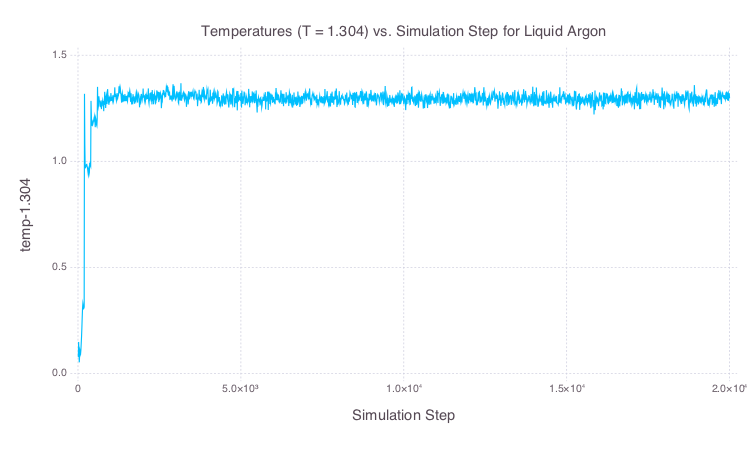

In [44]:
temp_plots[2]

The velocity distributions are clearly Maxwell-Boltzmann distributions:

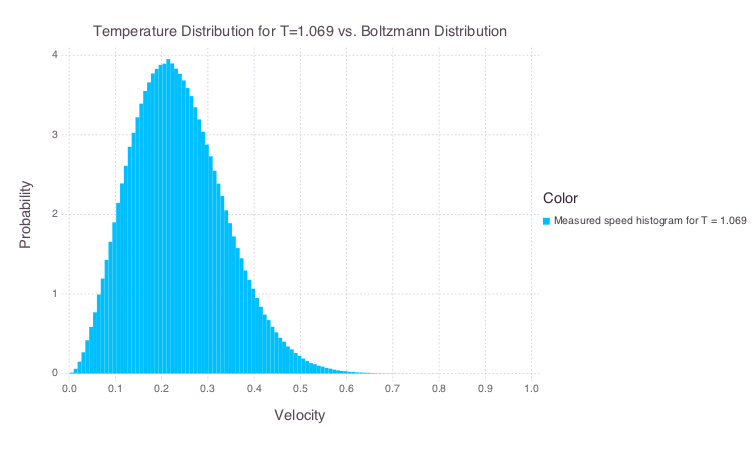

In [45]:
speed_plots[1]

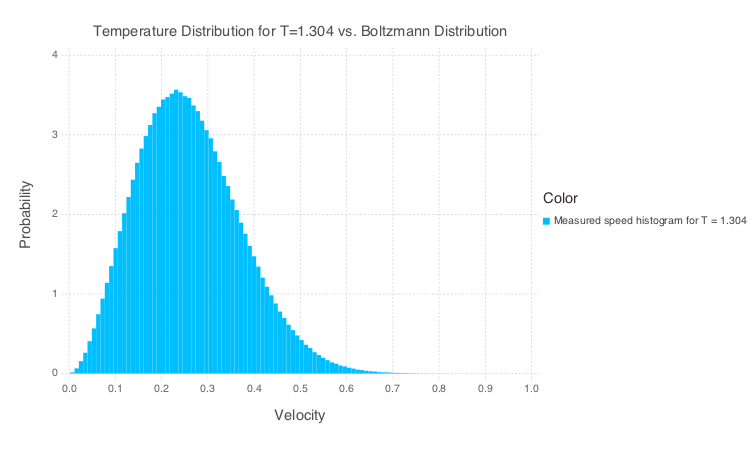

In [46]:
speed_plots[2]

We can also see that energy is conserved. There are minor fluctuations in total energy, but, importantly, the average remains stable over 16,000 steps:

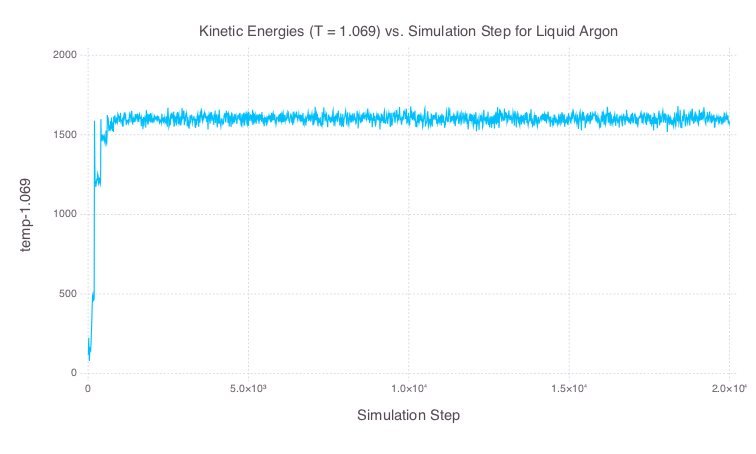

In [47]:
ke_plots[1]

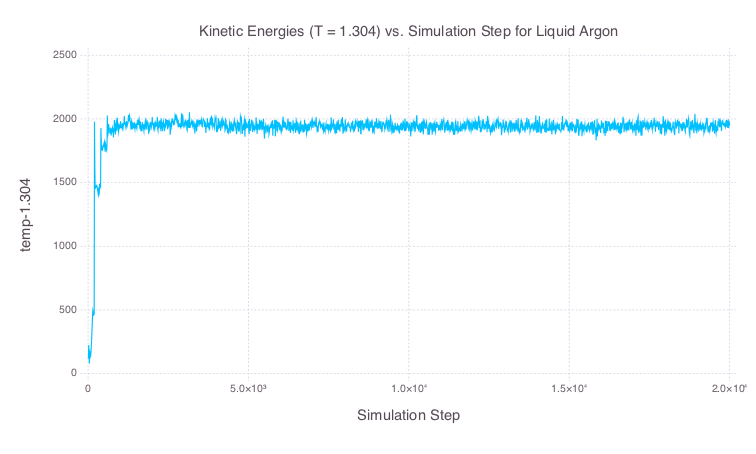

In [48]:
ke_plots[2]

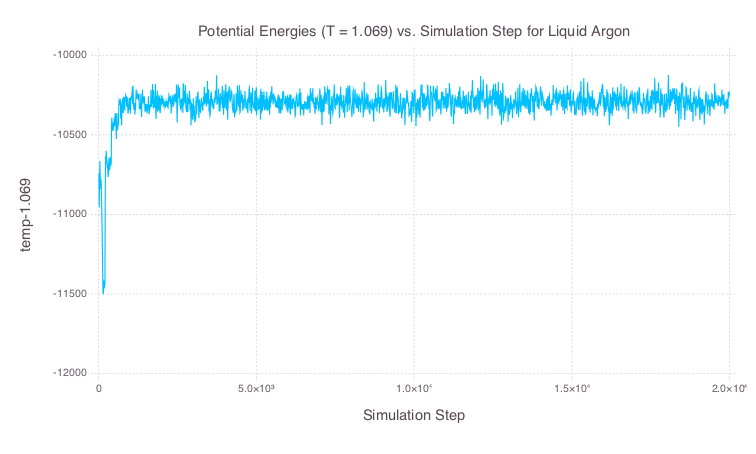

In [49]:
pe_plots[1]

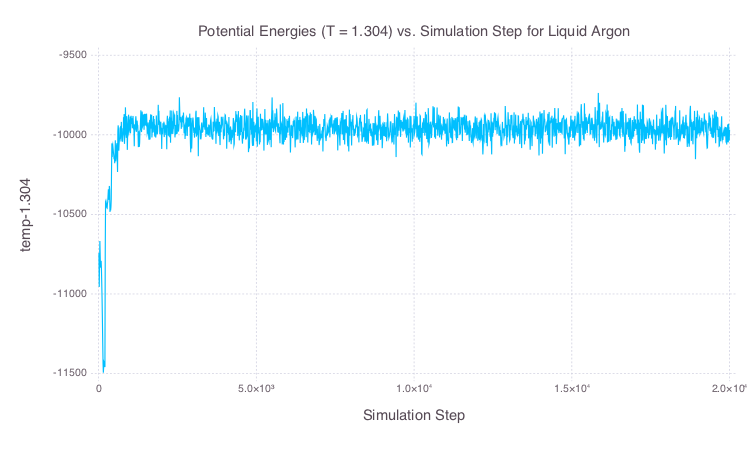

In [50]:
pe_plots[2]

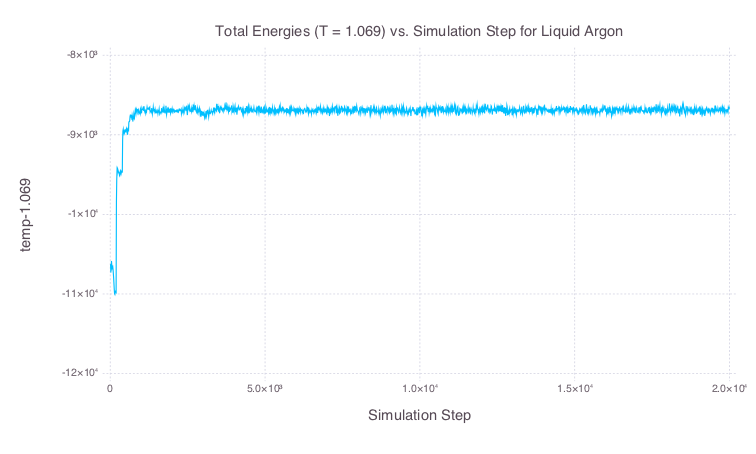

In [51]:
e_plots[1]

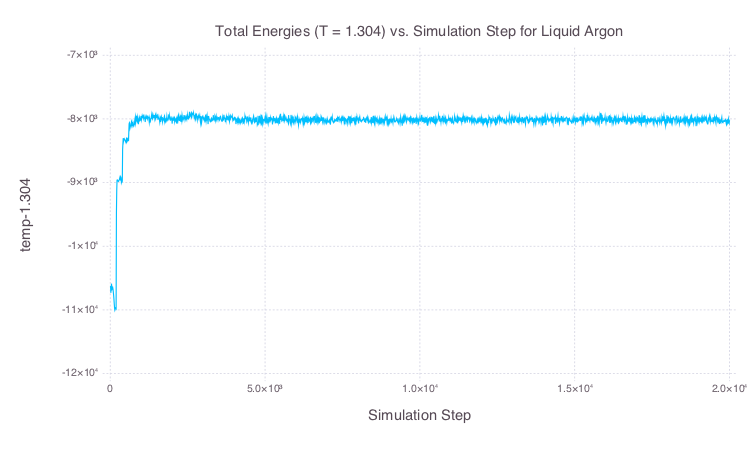

In [52]:
e_plots[2]